Attila Cangi, 14.02.2020 \
Normand Modine, 01.04.2020

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import integrate
from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import root_scalar
from scipy.optimize import bisect
from scipy.optimize import toms748
from scipy.special import spence
import mpmath as mp
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read
from functools import partial

Parameters

In [2]:
# Temperature
temp = 298

# Boltzmann's constant
kB = 8.617333262145e-5

# Conversion factor from Rydberg to eV
Ry2eV = 13.6056980659

# Conversion factor from Bohr to Angstroms
Br2AA = 0.52917721

# Gaussian smearing in QE-DOS calculations
# taken from QE-DOS input file
sigma_qe = 0.032

# Read and analyze QE calculated LDOS for snapshot 2
read_QE_LDOS = False

# Read and analyze Machine Learned LDOS for snapshot 2
read_ML_LDOS = False

Define a structure to hold the relevant results of each Density-Functional-Theory calculation

In [3]:
# Class that encapsulates the relevant results of a DFT calculation read from a file
class DFT_results:
    def __init__(self, out_file):
        # input:
        ## out_file: path to the output file from a DFT run using a code that ase.io.read can read
        # attributes (you probably should consider all of these to be read only):
        ## out_file: the DFT output file used to construct the object
        ## eigs: the Kohn-Sham eigenvalues
        ### eigs rows: band index, row i: eigs[i , :]
        ### eigs cols: k points,   col j: eigs[: , j]
        ## kpoints: the kpoints used in the calculation
        ## kweights: the kweights for the kpoints used in the calculation
        ## fermi_energy: the Fermi energy printed in the output file
        ### note that the Fermi energy is not printed to enought digits to give an accurate number of electrons
        
        atoms = read(filename=out_file)
        self.out_file = out_file
        self.eigs = np.transpose(atoms.get_calculator().band_structure().energies[0,:,:])
        self.kpoints = atoms.get_calculator().get_ibz_k_points()
        self.kweights = atoms.get_calculator().get_k_point_weights()
        self.fermi_energy = atoms.get_calculator().get_fermi_level()
        self.volume = atoms.get_volume()
        # I'd rather not do the following "grep" type search, but I can't find a ASE command to get n_electrons
        with open(out_file) as out:
            for line in out:
                if "number of electrons       =" in line:
                    self.n_electrons = np.float64(line.split('=')[1])
                    break

Define a structure to hold the results of a Density-of-State calculation

Compute the DOS on a grid of E values using its naive definition
$$ D(E) = \sum_i \sum_k w_k\, \delta(E-\epsilon_{ik})$$
where $i$ labels the band and $k$ the k point.  The $\delta$-functions appearing in this definition are represented on a grid by the function parameter delta_f.

In [4]:
# Class that encapsulates the results of a Density-of-States calculation
class DOS:
    def __init__(self, dft, e_grid, dos):
        # You probably should not call this constructer directly.
        # Instead you should call one of the factory methods:
        ## DOS.from_calculation(dft, e_grid, delta_f)
        ## DOS.from_dos_file(dft, file)
        ## DOS.from_ldos_data(dft,e_grid,ldos_data)
        # attributes (you probably should consider all of these to be read only):
        ## dft: the DFT_results instance used to generate the DOS
        ## e_grid: the array of energy values at which the DOS is evauated
        ## dos: the DOS evaluated at the energies in e_grid
        
        self.dft = dft
        self.e_grid = e_grid
        self.dos = dos
            
    @classmethod
    def from_calculation(cls, dft, e_grid, delta_f):
        # input:
        ## dft: a DFT_results instance
        ## e_grid: energy grid [eV] on which to evaluate the DOS
        ## delta_f: a function that represents a delta function on a grid
        
        dos_per_band = delta_f(e_grid,dft.eigs)
        dos_per_band = dft.kweights[np.newaxis,:,np.newaxis]*dos_per_band
        dos = np.sum(dos_per_band,axis=(0,1))
        return cls(dft, e_grid, dos)
    
    @classmethod
    def from_dos_file(cls, dft, file):
        # input:
        ## dft: a DFT_results instance
        ## file: a file containing an energy grid and a dos as columns
        ##       The first line of this file is considered a comment and skipped.
        
        data = np.loadtxt(file, skiprows=1)
        e_grid = data[:,0]
        dos = data[:,1]
        return cls(dft, e_grid, dos)
    
    @classmethod
    def from_ldos_data(cls, dft, e_grid, ldos_data):
        # input:
        ## dft: a DFT_results instance
        ## e_grid: energy grid [eV] on which the LDOS has been evaluated
        ## ldos_data: a 4-dimensional Numpy array containing LDOS results
        
        if ldos_data.shape[3] != e_grid.shape[0]:
            raise ValueError('Size of e_grid does not match length of 4th axis of ldos_data')
        cell_volume = dft.volume/(ldos_data.shape[0]*ldos_data.shape[1]*ldos_data.shape[2]*Br2AA**3)
        dos = np.sum(ldos_data, axis=(0,1,2))*cell_volume
        return cls(dft, e_grid, dos)   

In [5]:
# Class that encapsulates the results of a Local-Density-of-States calculation
class LDOS:
    def __init__(self, dft, e_grid, file):
        # input:
        ## dft: a DFT_results instance
        ## e_grid: energy grid [eV] on which the LDOS has been evaluated
        ## file: a file containing LDOS results in numpy format
        # attributes (you probably should consider all of these to be read only):
        ## dft: the DFT_results instance used to generate the DOS
        ## e_grid: the array of energy values at which the DOS is evauated
        ## ldos: the LDOS read from the file
        ## dos: the DOS evaluated from the LDOS
        
        self.dft = dft
        self.e_grid = e_grid
        self.ldos = np.load(file)
        self.ldos = self.ldos / Ry2eV  # Quantum Espresso calculates LDOS per Ry.  We use per eV units.
        self.cell_volume = dft.volume/(self.ldos.shape[0]*self.ldos.shape[1]*self.ldos.shape[2]*Br2AA**3)
        self.dos = DOS.from_ldos_data(dft,e_grid,self.ldos)
        self.e_fermi = dos_2_efermi(self.dos)
        self.eband = dos_2_eband(self.dos, e_fermi = self.e_fermi)
        dw = get_density_weights(self.e_grid, self.e_fermi, temp)
        self.density = np.sum(self.ldos*dw[np.newaxis,np.newaxis,np.newaxis,:], axis=(3))

In [6]:
dft_0_444 = DFT_results('snap_0/slurm-1006575.out')
dft_0_555 = DFT_results('snap_0_555/slurm-1001448.out')
dft_0_666 = DFT_results('snap_0_666/200327132835.out')
dft_0_888 = DFT_results('snap_0_888/200409131941.out')
dft_1_444 = DFT_results('snap_1/slurm-1006846.out')
dft_1_888 = DFT_results('snap_1_888/200409131805.out')
dft_2_888 = DFT_results('snap_2_888/200413195430.out')

eigs_qe = dft_0_888.eigs
kpoints_qe = dft_0_888.kpoints
k_weights_qe = dft_0_888.kweights
fermi_energy = dft_0_888.fermi_energy

eigs_qe_01 = dft_1_444.eigs
k_weights_qe_01 = dft_1_444.kweights

Define functions

The Fermi-Dirac distribution function is needed to evaluate the occupations of the Kohn-Sham states as a function of energy

In [7]:
dos_qe_0_888_g = DOS.from_dos_file(dft_0_888, 'snap_0_888/Al.dos_g')
dos_qe_0_888_2g = DOS.from_dos_file(dft_0_888, 'snap_0_888/Al.dos_2g')
dos_qe_1_888_2g = DOS.from_dos_file(dft_1_888, 'snap_1_888/Al.dos_2g')
dos_qe_2_888_2g = DOS.from_dos_file(dft_2_888, 'snap_2_888/Al.dos_2g')

In [8]:
# Fermi-Dirac distribution function
def fd_function(energies, e_fermi, temperature):                                                                                                 
    return 1.0 / (1.0 + np.exp((energies - e_fermi) / (kB * temperature)))

A Gaussian is one possible representation of the $\delta$-functions occuring in DOS definition
$$\delta(\epsilon-\epsilon_{ik}) = \frac{1}{\sqrt{\pi\sigma^2}}\exp{\left[-\left(\frac{\epsilon-\epsilon_{ik}}{\sigma}\right)^2\right]}$$ 
with a width $\sigma$.

In [9]:
# Define the integral of the Fermi Function
## Note that this could be written as an array operation in Numpy using ln(exp(2*cosh(x/2))),
## but I am using the mpmath polylog() function for consistency and to avoid over/underflow
def fermi_integral_0(energies, e_fermi, temperature):
    xa = (energies - e_fermi) / (kB * temperature)
    results = np.array([])
    for x in xa:
        results = np.append(results, np.float64(kB * temperature * (x + mp.polylog(1,-mp.exp(x)))))
    return results

In [10]:
# Define the integral of the Fermi Function times the energy (relative to the Fermi energy)
## Note that this could be written as an array operation in Numpy using ln(exp(2*cosh(x/2))) and np.spence()
## but I am using the mpmath polylog() function for consistency and to avoid over/underflow
def fermi_integral_1(energies, e_fermi, temperature):
    xa = (energies - e_fermi) / (kB * temperature)
    results = np.array([])
    for x in xa:
        results = np.append(results, np.float64((kB * temperature)**2 *
                            (x**2/2.0 + x*mp.polylog(1,-mp.exp(x)) - mp.polylog(2,-mp.exp(x))) ))
    return results

In [11]:
# Define the integral of the Fermi Function times the energy (relative to the Fermi energy) squared
## As far as I can tell, there is no polylog(3,x) function for Numpy so I am using mpmath
## This also helps avoid over/underflow.
def fermi_integral_2(energies, e_fermi, temperature):
    xa = (energies - e_fermi) / (kB * temperature)
    results = np.array([])
    for x in xa:
        results = np.append(results, np.float64((kB * temperature)**3 *
                                                ( x**3/3.0 + x**2 * mp.polylog(1,-mp.exp(x))
                                                  - 2.0*x*mp.polylog(2,-mp.exp(x))
                                                  + 2.0*mp.polylog(3,-mp.exp(x)) ) ))
    return results

In [12]:
#  Test the Fermi integral functions against quadrature
energies = np.array([6.83,7.11])
e_fermi = 7.0
fi_0 = fermi_integral_0(energies, e_fermi, temp)
aint_0 = fi_0[1] - fi_0[0]
qint_0, abserr = sp.integrate.quad(
        lambda e: fd_function(e, e_fermi, temp),
        energies[0],energies[-1])
print(aint_0)
print(qint_0)
print(aint_0 - qint_0)
fi_1 = fermi_integral_1(energies, e_fermi, temp)
aint_1 = fi_1[1] - fi_1[0]
qint_1, abserr = sp.integrate.quad(
        lambda e: (e - e_fermi)*fd_function(e, e_fermi, temp),
        energies[0],energies[-1])
print(aint_1)
print(qint_1)
print(aint_1 - qint_1)
fi_2 = fermi_integral_2(energies, e_fermi, temp)
aint_2 = fi_2[1] - fi_2[0]
qint_2, abserr = sp.integrate.quad(
        lambda e: (e - e_fermi)**2*fd_function(e, e_fermi, temp),
        energies[0],energies[-1])
print(aint_2)
print(qint_2)
print(aint_2 - qint_2)

0.1696824228988496
0.16968242289884924
3.608224830031759e-16
-0.013419715723285694
-0.01341971572328568
-1.3877787807814457e-17
0.0016322822031528137
0.0016322822031528126
1.0842021724855044e-18


In [13]:
# Calculate weights that will compute the analytic integral of the Fermi function
#   times an arbitrary linearly interpolated function
def get_density_weights(energies, e_fermi, temperature):
    fi_0 = fermi_integral_0(energies, e_fermi, temperature)
    fi_0 = fi_0[1:] - fi_0[:-1]
    fi_1 = fermi_integral_1(energies, e_fermi, temperature)
    fi_1 = fi_1[1:] - fi_1[:-1]
    weights = np.zeros(energies.size)
    delta_e = energies[1:] - energies[:-1]
    weights[1:] = weights[1:] + fi_1/delta_e
    weights[1:] = weights[1:] + fi_0 * (1.0 + (e_fermi - energies[1:])/delta_e)
    weights[:-1] = weights[:-1] - fi_1/delta_e
    weights[:-1] = weights[:-1] + fi_0 * (1.0 - (e_fermi - energies[:-1])/delta_e)
    return weights

In [14]:
# Calculate weights that will compute the analytic integral of the Fermi function
# times the energy times an arbitrary linearly interpolated function
def get_energy_weights(energies, e_fermi, temperature):
    fi_1 = fermi_integral_1(energies, e_fermi, temperature)
    fi_1 = fi_1[1:] - fi_1[:-1]
    fi_2 = fermi_integral_2(energies, e_fermi, temperature)
    fi_2 = fi_2[1:] - fi_2[:-1]
    weights = np.zeros(energies.size)
    delta_e = energies[1:] - energies[:-1]
    weights[1:] = weights[1:] + fi_2/delta_e
    weights[1:] = weights[1:] + fi_1 * (1.0 + (e_fermi - energies[1:])/delta_e)
    weights[:-1] = weights[:-1] - fi_2/delta_e
    weights[:-1] = weights[:-1] + fi_1 * (1.0 - (e_fermi - energies[:-1])/delta_e)
    weights = weights + e_fermi*get_density_weights(energies, e_fermi, temperature)
    return weights

In [15]:
# Calculate the analytic integral of the Fermi function times the linearly interpolated dos
def analytic_enum(energies, dos, e_fermi, temperature):
    return np.sum(dos*get_density_weights(energies, e_fermi, temperature))

In [16]:
# Calculate the analytic integral of the Fermi function times the linearly interpolated dos
def analytic_enum2(energies, dos, e_fermi, temperature):
    fi_0 = fermi_integral_0(energies, e_fermi, temperature)
    fi_1 = fermi_integral_1(energies, e_fermi, temperature)
    delta_e = energies[1:] - energies[:-1]
    delta_dos = dos[1:] - dos[:-1]
    slope = delta_dos / delta_e
    fermi_intercept = (energies[1:]*dos[:-1] - energies[:-1]*dos[1:])/delta_e + slope*e_fermi
    return np.sum((fi_0[1:] - fi_0[:-1])*fermi_intercept + (fi_1[1:] - fi_1[:-1])*slope)

In [17]:
# Calculate the analytic integral of the Fermi function times the linearly interpolated dos times the energy
def analytic_eband(energies, dos, e_fermi, temperature):
    return np.sum(dos*get_energy_weights(energies, e_fermi, temperature))

In [18]:
# Calculate the analytic integral of the Fermi function times the linearly interpolated dos times the energy
def analytic_eband2(energies, dos, e_fermi, temperature):
    fi_0 = fermi_integral_0(energies, e_fermi, temperature)
    fi_1 = fermi_integral_1(energies, e_fermi, temperature)
    fi_2 = fermi_integral_2(energies, e_fermi, temperature)
    delta_e = energies[1:] - energies[:-1]
    delta_dos = dos[1:] - dos[:-1]
    slope = delta_dos / delta_e
    fermi_intercept = (energies[1:]*dos[:-1] - energies[:-1]*dos[1:])/delta_e + slope*e_fermi
    return np.sum((fi_0[1:] - fi_0[:-1])*fermi_intercept*e_fermi
                + (fi_1[1:] - fi_1[:-1])*(fermi_intercept + slope*e_fermi)
                + (fi_2[1:] - fi_2[:-1])*slope)

In [19]:
# Define Gaussian
## Note: Gaussian without factor of 1/sqrt(2)
def gaussian(e_grid, centers, sigma):
    result = 1.0/np.sqrt(np.pi*sigma**2)*np.exp(-1.0*((e_grid[np.newaxis]-centers[...,np.newaxis])/sigma)**2)
    return result

In [20]:
# Define a discretized delta function that maintains 0th and 1st moments
def delta_M1(e_grid, centers):
    de = e_grid[np.newaxis]-centers[...,np.newaxis]
    de_above = np.min(de,axis=-1,initial=np.max(de),where=np.greater(de,0.0))
    de_below = np.max(de,axis=-1,initial=np.min(de),where=np.less_equal(de,0.0))
    e_spacing = de_above - de_below
    result = 1.0 - np.abs(de)/e_spacing[...,np.newaxis]
    result = result*np.greater_equal(result,0.0)*np.less_equal(result,1.0)
    result = result/e_spacing[...,np.newaxis]
    return result

The total number of electrons is obtained directly from the Kohn-Sham eigenvalues $\epsilon_{ik}$ by summing the occupations over all of the states

$$E_{band} = \sum_i \sum_k w_k\, f(\epsilon_{ik})\ ,$$

where $i$ labels the band, $k$ labels the k point, $w_k$ is the weight of the k point, and $f(\epsilon_{ik})$ is the occupation of the state, which is given by the Fermi-Dirac distribution function evaluated at energy $\epsilon_{ik}$.  The weights $w_k$ arise from an implicit integral over the Brillouin zone, which is evaluated as a simple sum over a regular grid of k points.  This simple approach to evaluating the integral often gives reasonable results since $\epsilon_{ik}$ is periodic in $k$, but it becomes less accurate when the Fermi level lies within a band due to the non-analytic behavior of the Fermi-Dirac function at the Fermi level. The sum over a regular grid of k-points is additionally reduced by symmetry, which results in different $w_k$ values for different $k$ values.

In [21]:
# Function generating the number of electrons from DFT results
def dft_2_enum(dft, e_fermi = None, temperature = temp):
    # input:
    ## dft: a DFT_results instance
    ## e_fermi: Fermi energy used in generating the occupations, defaults to Fermi energy from dft
    ## temperature: temperature used in generating the occupations
    # output:
    ## enum: number of electrons

    if e_fermi is None:
        e_fermi = dft.fermi_energy
    enum_per_band = fd_function(dft.eigs, e_fermi=e_fermi, temperature=temperature)
    enum_per_band = dft.kweights[np.newaxis,:]*enum_per_band
    enum = np.sum(enum_per_band)
    return enum

The "band energy," which is also called the "single-particle energy" or the "one-electron energy," is obtained directly from the Kohn-Sham eigenvalues $\epsilon_{ik}$ from a weighted sum of the eigenvalues

$$E_{band} = \sum_i \sum_k w_k\, f(\epsilon_{ik}) \epsilon_{ik}\ ,$$

where the various terms are defined above.

In [22]:
# Function generating band energy from DFT results
def dft_2_eband(dft, e_fermi = None, temperature = temp):
    # input:
    ## dft: a DFT_results instance
    ## e_fermi: Fermi energy used in generating the occupations, defaults to Fermi energy from dft
    ## temperature: temperature used in generating the occupations
    # output:
    ## eband: band energy

    if e_fermi is None:
        e_fermi = dft.fermi_energy
    elif e_fermi == "self-consistent" or e_fermi == "sc":
        e_fermi = toms748(lambda e_fermi: dft_2_enum(dft, e_fermi, temperature) - dft.n_electrons, a = np.min(dft.eigs), b = np.max(dft.eigs))
    eband_per_band = dft.eigs*fd_function(dft.eigs, e_fermi=e_fermi, temperature=temperature)
    eband_per_band = dft.kweights[np.newaxis,:]*eband_per_band
    eband = np.sum(eband_per_band)
    return eband

In [23]:
eband_0_888_ref=dft_2_eband(dft_0_888)
print(eband_0_888_ref)

2595.3654808767733


In [24]:
eband_0_888_sc_ref=dft_2_eband(dft_0_888, e_fermi = 'sc')
print(eband_0_888_sc_ref)

2595.3470902759054


In [25]:
eband_1_888_ref=dft_2_eband(dft_1_888)
print(eband_1_888_ref)

2598.146096688316


In [26]:
eband_1_888_sc_ref=dft_2_eband(dft_1_888, e_fermi = 'sc')
print(eband_1_888_sc_ref)

2598.1203692340027


In [27]:
eband_2_888_ref=dft_2_eband(dft_2_888)
print(eband_2_888_ref)

2595.8711214367395


In [28]:
eband_2_888_sc_ref=dft_2_eband(dft_2_888, e_fermi = 'sc')
print(eband_2_888_sc_ref)

2595.876315137265


In [29]:
enum_0_888_ref=dft_2_enum(dft_0_888)
print(enum_0_888_ref)

768.0023586003111


In [30]:
enum_1_888_ref=dft_2_enum(dft_1_888)
print(enum_1_888_ref)

768.0032983385398


In [31]:
enum_2_888_ref=dft_2_enum(dft_2_888)
print(enum_2_888_ref)

767.9993338972209


Alternatively, the total number of electrons can be obtained from the DOS

$$E_{band} = \int_{-\infty}^{\infty} dE\ D(E)\, f(E)\,$$

where $E$ denotes the energy, $D(E)$ the DOS, and $f(E)$ the Fermi-Dirac distribution function.

In [32]:
# Function generating integrated density (electron number) from DOS
## Integrate DOS*FD to obtain band energy
def dos_2_enum(dos, e_fermi = None, temperature = temp, integration = 'analytic'):
    # input:
    ## dos: a DOS instance
    ## e_fermi: Fermi energy used in generating the occupations, defaults to Fermi energy from dft
    ## temperature: temperature used in generating the occupations
    ## integration: method of integration, which can be one of the following strings:
    ### 'trapz': sp.integrate.trapz
    ### 'simps': sp.integrate.simps
    ### 'quad': sp.integrate.quad with linear interpolation of dos using sp.interpolate.interp1d
    ### 'analytic': analytic integration of the Fermi function times the linearly interpolated dos
    # output:
    ## enum: number of electrons
    
    if e_fermi is None:
        e_fermi = dos.dft.fermi_energy
    if integration == 'trapz':
        occupations = fd_function(dos.e_grid, e_fermi, temperature)
        enum = sp.integrate.trapz(dos.dos * occupations, dos.e_grid)
    elif integration == 'simps':
        occupations = fd_function(dos.e_grid, e_fermi, temperature)
        enum = sp.integrate.simps(dos.dos * occupations, dos.e_grid)
    elif integration == 'quad':
        f_dos = sp.interpolate.interp1d(dos.e_grid,dos.dos)
        enum, abserr = sp.integrate.quad(
            lambda e: f_dos(e)*fd_function(e, e_fermi, temperature),
            dos.e_grid[0], dos.e_grid[-1], limit=500, points=(e_fermi))
    elif integration == 'analytic':
        enum = analytic_enum(dos.e_grid, dos.dos, e_fermi, temperature)
    else:
        raise ValueError('argument "integration" does not match an implemented method')
    return enum

In [33]:
# Calculate the self-consistent Fermi energy such that dos_2_enum(...) = dos.dft.n_electrons
def dos_2_efermi(dos, temperature = temp, integration = 'analytic'):
    # input:
    ## dos: a DOS instance
    ## temperature: temperature used in generating the occupations
    ## integration: method of integration, which can be one of the following strings:
    ### 'trapz': sp.integrate.trapz
    ### 'simps': sp.integrate.simps
    ### 'quad': sp.integrate.quad with linear interpolation of dos using sp.interpolate.interp1d
    ### 'analytic': analytic integration of the Fermi function times the linearly interpolated dos
    # output:
    ## e_fermi: the self-consistent Fermi energy
    
    e_fermi = toms748(lambda e_fermi: dos_2_enum(dos, e_fermi, temperature, integration) - dos.dft.n_electrons,
                          a = dos.e_grid[0], b = dos.e_grid[-1])
    return e_fermi

Similarly, the band energy can be obtained from the DOS

$$E_{band} = \int_{-\infty}^{\infty} dE\ D(E)\, f(E)\, E .$$


In [34]:
# Function generating band energy from DOS
## Integrate E*DOS*FD to obtain band energy
def dos_2_eband(dos, e_fermi = None, temperature = temp, integration = 'analytic'):
    # input:
    ## dos: a DOS instance
    ## e_fermi: Fermi energy used in generating the occupations, defaults to Fermi energy from dft
    ## temperature: temperature used in generating the occupations
    ## integration: method of integration, which can be one of the following strings:
    ### 'trapz': sp.integrate.trapz
    ### 'simps': sp.integrate.simps
    ### 'quad': sp.integrate.quad with linear interpolation of dos using sp.interpolate.interp1d
    ### 'analytic': analytic integration of the Fermi function times the energy times the linearly interpolated dos
    # output:
    ## eband: calculated band energy in eV
    
    if e_fermi is None:
        e_fermi = dos.dft.fermi_energy
    elif e_fermi == "self-consistent" or e_fermi == "sc":
        e_fermi = dos_2_efermi(dos, temperature, integration)
    if integration == 'trapz':
        occupations = fd_function(dos.e_grid, e_fermi, temperature)
        eband = sp.integrate.trapz(dos.e_grid * dos.dos * occupations, dos.e_grid)
    elif integration == 'simps':
        occupations = fd_function(dos.e_grid, e_fermi, temperature)
        eband = sp.integrate.simps(dos.e_grid * dos.dos * occupations, dos.e_grid)
    elif integration == 'quad':
        f_dos = sp.interpolate.interp1d(dos.e_grid,dos.dos)
        eband, abserr = sp.integrate.quad(
            lambda e: f_dos(e)*e*fd_function(e, e_fermi, temperature),
            dos.e_grid[0], dos.e_grid[-1], limit=500, points=(e_fermi))
    elif integration == 'analytic':
        eband = analytic_eband(dos.e_grid, dos.dos, e_fermi, temperature)
    else:
        raise ValueError('argument "integration" does not match an implemented method')
    return eband

Compute total DOS

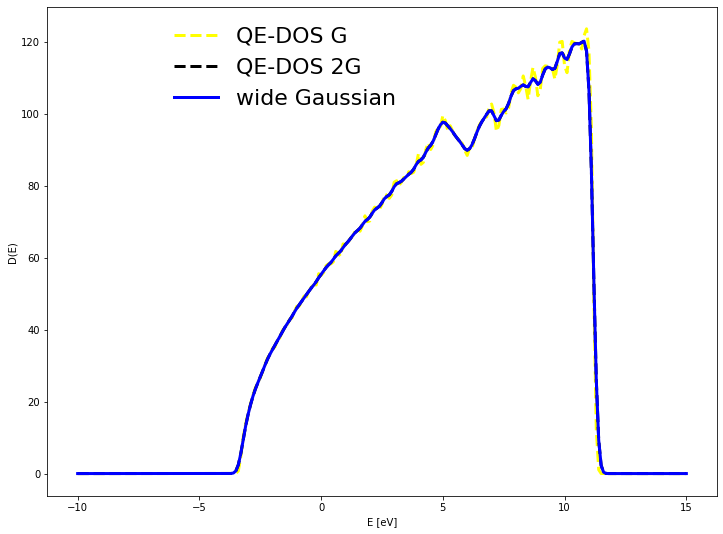

In [35]:
# Use the same grid as used by the Quantum Espresso postprocessor
e_grid = dos_qe_0_888_g.e_grid
#e_grid = np.arange(-5.0,15.0,0.1)

# Determine the smearing for the Gaussian representation of the delta function
sigma = e_grid[1] - e_grid[0]
narrow_gaussian = partial(gaussian, sigma = sigma)
wide_gaussian = partial(gaussian, sigma = 2.0*sigma)

# Compute the DOS for snap_0 with 888 k-points using each representation of the delta function
dos_0_888_g = DOS.from_calculation(dft_0_888, e_grid, narrow_gaussian )
dos_0_888_2g = DOS.from_calculation(dft_0_888, e_grid, wide_gaussian )
dos_0_888_M1 = DOS.from_calculation(dft_0_888, e_grid, delta_M1)

# Compute the DOS for snap_1 with 888 k-points using each representation of the delta function
dos_1_888_g = DOS.from_calculation(dft_1_888, e_grid, narrow_gaussian )
dos_1_888_2g = DOS.from_calculation(dft_1_888, e_grid, wide_gaussian )
dos_1_888_M1 = DOS.from_calculation(dft_1_888, e_grid, delta_M1)

# Compute the DOS for snap_2 with 888 k-points using each representation of the delta function
dos_2_888_g = DOS.from_calculation(dft_2_888, e_grid, narrow_gaussian )
dos_2_888_2g = DOS.from_calculation(dft_2_888, e_grid, wide_gaussian )
dos_2_888_M1 = DOS.from_calculation(dft_2_888, e_grid, delta_M1)
        
# Plot data        
plt.figure(figsize=[12,9])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe_0_888_g.e_grid, dos_qe_0_888_g.dos, linestyle='--', linewidth=3, color='yellow', label='QE-DOS G')
ax.plot(dos_qe_0_888_2g.e_grid, dos_qe_0_888_2g.dos, linestyle='--', linewidth=3, color='black', label='QE-DOS 2G')
ax.plot(dos_0_888_2g.e_grid, dos_0_888_2g.dos, linestyle='-', linewidth=3, color='blue',  label='wide Gaussian')
#ax.plot(dos_0_888_g.e_grid, dos_0_888_g.dos, linestyle='-', linewidth=3, color='green',  label='narrow Gaussian')
#ax.plot(dos_0_888_M1.e_grid, dos_0_888_M1.dos, linestyle='-', linewidth=3, color='red',  label='M1 delta representation')


# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(0.55, 1.0))
plt.show()

We can recover the QE-DOS result by using the same parameters as in the input for computing the DOS.

Now we can go ahead and investigate different energy grids and smearing values in order to improve upon the band energy and achieve better agreement with the band-energy output of QE.

In [36]:
print(dos_2_enum(dos_0_888_2g, integration = 'quad') - enum_0_888_ref)
print(dos_2_enum(dos_0_888_g, integration = 'quad') - enum_0_888_ref)
print(dos_2_enum(dos_0_888_M1, integration = 'quad') - enum_0_888_ref)

<ipython-input-32-0b6daeae7aaf>:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  enum, abserr = sp.integrate.quad(


0.28304728577404603
0.10647239198749503
0.04538864728692715


In [37]:
print(dos_2_enum(dos_0_888_2g, integration = 'analytic') - enum_0_888_ref)
print(dos_2_enum(dos_0_888_g, integration = 'analytic') - enum_0_888_ref)
print(dos_2_enum(dos_0_888_M1, integration = 'analytic') - enum_0_888_ref)

0.28310624238542914
0.10668622714081266
0.04539697333029835


In [38]:
print(dos_2_enum(dos_qe_0_888_2g, integration = 'analytic') - enum_0_888_ref)
print(dos_2_enum(dos_qe_0_888_g, integration = 'analytic') - enum_0_888_ref)

0.28325765921397306
0.1065453373927312


In [39]:
print(dos_2_enum(dos_1_888_2g, integration = 'quad') - enum_1_888_ref)
print(dos_2_enum(dos_1_888_g, integration = 'quad') - enum_1_888_ref)
print(dos_2_enum(dos_1_888_M1, integration = 'quad') - enum_1_888_ref)

<ipython-input-32-0b6daeae7aaf>:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  enum, abserr = sp.integrate.quad(


0.28533298020636266
0.10744953331345641
0.052445261101411234


In [40]:
print(dos_2_enum(dos_1_888_2g, integration = 'analytic') - enum_1_888_ref)
print(dos_2_enum(dos_1_888_g, integration = 'analytic') - enum_1_888_ref)
print(dos_2_enum(dos_1_888_M1, integration = 'analytic') - enum_1_888_ref)

0.2856521550979778
0.10731624971231213
0.052275393386821634


In [41]:
print(dos_2_enum(dos_qe_1_888_2g, integration = 'analytic') - enum_1_888_ref)

0.28996261895224507


In [42]:
print(dos_2_enum(dos_2_888_2g, integration = 'quad') - enum_2_888_ref)
print(dos_2_enum(dos_2_888_g, integration = 'quad') - enum_2_888_ref)
print(dos_2_enum(dos_2_888_M1, integration = 'quad') - enum_2_888_ref)

<ipython-input-32-0b6daeae7aaf>:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  enum, abserr = sp.integrate.quad(


0.24194209412007694
0.07849218150795423
0.027242952126243836


In [43]:
print(dos_2_enum(dos_2_888_2g, integration = 'analytic') - enum_2_888_ref)
print(dos_2_enum(dos_2_888_g, integration = 'analytic') - enum_2_888_ref)
print(dos_2_enum(dos_2_888_M1, integration = 'analytic') - enum_2_888_ref)

0.24220842096963224
0.07857100610215184
0.027246274673416337


In [44]:
print(dos_2_enum(dos_qe_2_888_2g, integration = 'analytic') - enum_2_888_ref)

0.2487092959330539


In [45]:
print(dos_2_eband(dos_0_888_2g, integration = 'quad') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_g, integration = 'quad') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_M1, integration = 'quad') - eband_0_888_ref)

<ipython-input-34-1b959d83657e>:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  eband, abserr = sp.integrate.quad(


1.0630292256505527
0.4771164300154851
0.17639036704667888


In [46]:
print(dos_2_eband(dos_0_888_2g, integration = 'analytic') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_g, integration = 'analytic') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_M1, integration = 'analytic') - eband_0_888_ref)

1.064013783009159
0.47773027019775327
0.17632259174706633


In [47]:
print(dos_2_eband(dos_0_888_2g, integration = 'trapz') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_g, integration = 'trapz') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_M1, integration = 'trapz') - eband_0_888_ref)

0.7286718881982779
0.06695301014724464
-0.27639639720928244


In [48]:
print(dos_2_eband(dos_0_888_2g, integration = 'simps') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_g, integration = 'simps') - eband_0_888_ref)
print(dos_2_eband(dos_0_888_M1, integration = 'simps') - eband_0_888_ref)

1.276224426794215
0.44716557464926154
0.16444612119903468


In [49]:
print(dos_2_eband(dos_qe_0_888_2g, integration = 'analytic') - eband_0_888_ref)
print(dos_2_eband(dos_qe_0_888_g, integration = 'analytic') - eband_0_888_ref)

1.076458786079911
0.50766853644609


In [50]:
print(dos_2_eband(dos_0_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)
print(dos_2_eband(dos_0_888_g, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)
print(dos_2_eband(dos_0_888_M1, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)

-1.142993832596403
-0.35408061825773984
-0.17764809464233622


In [51]:
print(dos_2_eband(dos_qe_0_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)
print(dos_2_eband(dos_qe_0_888_g, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)

-1.1317269716278133
-0.32304349481273675


In [52]:
print(dos_2_eband(dos_1_888_2g, integration = 'analytic') - eband_1_888_ref)
print(dos_2_eband(dos_1_888_g, integration = 'analytic') - eband_1_888_ref)
print(dos_2_eband(dos_1_888_M1, integration = 'analytic') - eband_1_888_ref)

1.0844960764566167
0.4831471591865011
0.22979756722861566


In [53]:
print(dos_2_eband(dos_qe_1_888_2g, integration = 'analytic') - eband_1_888_ref)

1.0794197056247867


In [54]:
print(dos_2_eband(dos_1_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_1_888_sc_ref)
print(dos_2_eband(dos_1_888_g, e_fermi = 'sc', integration = 'analytic') - eband_1_888_sc_ref)
print(dos_2_eband(dos_1_888_M1, e_fermi = 'sc', integration = 'analytic') - eband_1_888_sc_ref)

-1.1431815692762939
-0.35388643115402374
-0.1779532195914726


In [55]:
print(dos_2_eband(dos_qe_1_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_1_888_sc_ref)

-1.181866304027153


In [56]:
print(dos_2_eband(dos_2_888_2g, integration = 'analytic') - eband_2_888_ref)
print(dos_2_eband(dos_2_888_g, integration = 'analytic') - eband_2_888_ref)
print(dos_2_eband(dos_2_888_M1, integration = 'analytic') - eband_2_888_ref)

0.745995223531736
0.2597264144933433
0.03463604357057193


In [57]:
print(dos_2_eband(dos_qe_2_888_2g, integration = 'analytic') - eband_2_888_ref)

0.8088733359654725


In [58]:
print(dos_2_eband(dos_2_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)
print(dos_2_eband(dos_2_888_g, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)
print(dos_2_eband(dos_2_888_M1, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)

-1.1422852665114078
-0.3528987682757361
-0.17781404766901687


In [59]:
print(dos_2_eband(dos_qe_2_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)

-1.1300799679197553


We can go also investigate how quantities evaluated from the LDOS calculated either by Quantum Espresso
or by machine learning compare with the results evaluated from the DOS that we calculate from eigenvalues.

In [60]:
if read_QE_LDOS:
    ldos_e_grid = np.linspace(-10.0,14.9,250)
    ldos_2_888_2g = LDOS(dft_2_888, ldos_e_grid,
      '/Users/namodin/Documents/Machine Learning/ldos_data/ldos_200x200x200grid_250elvls_snapshot2.npy')

if read_ML_LDOS:
    ldos_e_grid = np.linspace(-10.0,14.9,250)
    ldos_ml_2_888_2g = LDOS(dft_2_888, ldos_e_grid,
      '/Users/namodin/Documents/Machine Learning/ldos_data/FeedForward_fp_ldos_predictions_may5.npy')

In [61]:
#  This checks how well the eband and electron density computed in various ways from the LDOS agree
if read_QE_LDOS:
    print(dos_2_eband(dos_2_888_2g, e_fermi = 'sc', integration = 'analytic'),
          dos_2_eband(dos_2_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)
    print(dos_2_eband(ldos_2_888_2g.dos, e_fermi = 'sc', integration = 'analytic'),
          dos_2_eband(ldos_2_888_2g.dos, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)
    print(ldos_2_888_2g.eband, ldos_2_888_2g.eband - eband_2_888_sc_ref)
    print(np.sum(ldos_2_888_2g.density)*ldos_2_888_2g.cell_volume,
          np.sum(ldos_2_888_2g.density)*ldos_2_888_2g.cell_volume - ldos_2_888_2g.dft.n_electrons)

In [62]:
#  This shows that I can get agreement with Austin's band energy for the ML predicted LDOS by altering parameters
if read_ML_LDOS:
    print(dos_2_eband(dos_2_888_2g, integration = 'simps'))
    print(dos_2_eband(ldos_ml_2_888_2g.dos, integration = 'simps'),
          dos_2_eband(ldos_ml_2_888_2g.dos, integration = 'simps') - dos_2_eband(dos_2_888_2g, integration = 'simps'))
    print("Changing energy grid!")
    ldos_ml_2_888_2g.dos.e_grid = np.linspace(-10.0,15.0,250)
    print(dos_2_eband(ldos_ml_2_888_2g.dos, integration = 'simps'))
    print(dos_2_eband(ldos_ml_2_888_2g.dos, e_fermi = 7.7967, integration = 'simps'))
    cell_volume = ldos_ml_2_888_2g.dft.volume/(200.0*Br2AA)**3
    print(cell_volume, cell_volume**(1.0/3.0))
    print(dos_2_eband(ldos_ml_2_888_2g.dos, e_fermi = 7.7967, integration = 'simps')*0.153049**3/cell_volume)
    print("Resetting energy grid!")
    ldos_ml_2_888_2g.dos.e_grid = np.linspace(-10.0,14.9,250)

In [63]:
#  This checks how well the eband and electron density computed in various ways from the LDOS agree
if read_ML_LDOS:
    print(dos_2_eband(dos_2_888_2g, e_fermi = 'sc', integration = 'analytic'),
          dos_2_eband(dos_2_888_2g, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)
    print(dos_2_eband(ldos_ml_2_888_2g.dos, e_fermi = 'sc', integration = 'analytic'),
          dos_2_eband(ldos_ml_2_888_2g.dos, e_fermi = 'sc', integration = 'analytic') - eband_2_888_sc_ref)
    print(ldos_ml_2_888_2g.eband, ldos_ml_2_888_2g.eband - eband_2_888_sc_ref)
    print(np.sum(ldos_ml_2_888_2g.density)*ldos_ml_2_888_2g.cell_volume,
          np.sum(ldos_ml_2_888_2g.density)*ldos_ml_2_888_2g.cell_volume - ldos_ml_2_888_2g.dft.n_electrons)

Now we will investigate how quantities calculated from various definitions of the DOS change as the energy grid is varied.  This both gives us an idea of the error associated with various definitions of the DOS and how much the error varies with details of the calculation (e.g., grid spacing).

In [64]:
emin = e_grid[0]
emax = e_grid[-1]
n_egrid_max = len(e_grid)
n_egrids = np.arange(n_egrid_max - 10, n_egrid_max + 1)

dosn_0_888_g = []
dosn_0_888_2g = []
dosn_0_888_M1 = []

for n_egrid in n_egrids:
    
    print(n_egrid)
    
    e_grid_n = np.linspace(emin, emax, n_egrid)
    sigma_mod = e_grid_n[1] - e_grid_n[0]
    narrow_gaussian = partial(gaussian, sigma = sigma)
    wide_gaussian = partial(gaussian, sigma = 2.0*sigma)

    dosn_0_888_g.append(DOS.from_calculation(dft_0_888, e_grid_n, narrow_gaussian ))
    dosn_0_888_2g.append(DOS.from_calculation(dft_0_888, e_grid_n, wide_gaussian ))
    dosn_0_888_M1.append(DOS.from_calculation(dft_0_888, e_grid_n, delta_M1))

241
242
243
244
245
246
247
248
249
250
251


In [65]:
enum_error_0_888_g = []
eband_error_0_888_g = []
for dos in dosn_0_888_g:
    enum_error_0_888_g.append(dos_2_enum(dos, integration = 'analytic') - enum_0_888_ref)
    eband_error_0_888_g.append(dos_2_eband(dos, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)
enum_error_0_888_g = np.array(enum_error_0_888_g)
eband_error_0_888_g = np.array(eband_error_0_888_g)

enum_error_0_888_2g = []
eband_error_0_888_2g = []
for dos in dosn_0_888_2g:
    enum_error_0_888_2g.append(dos_2_enum(dos, integration = 'analytic') - enum_0_888_ref)
    eband_error_0_888_2g.append(dos_2_eband(dos, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)
enum_error_0_888_2g = np.array(enum_error_0_888_2g)
eband_error_0_888_2g = np.array(eband_error_0_888_2g)

enum_error_0_888_M1 = []
eband_error_0_888_M1 = []
for dos in dosn_0_888_M1:
    enum_error_0_888_M1.append(dos_2_enum(dos, integration = 'analytic') - enum_0_888_ref)
    eband_error_0_888_M1.append(dos_2_eband(dos, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)
enum_error_0_888_M1 = np.array(enum_error_0_888_M1)
eband_error_0_888_M1 = np.array(eband_error_0_888_M1)
    

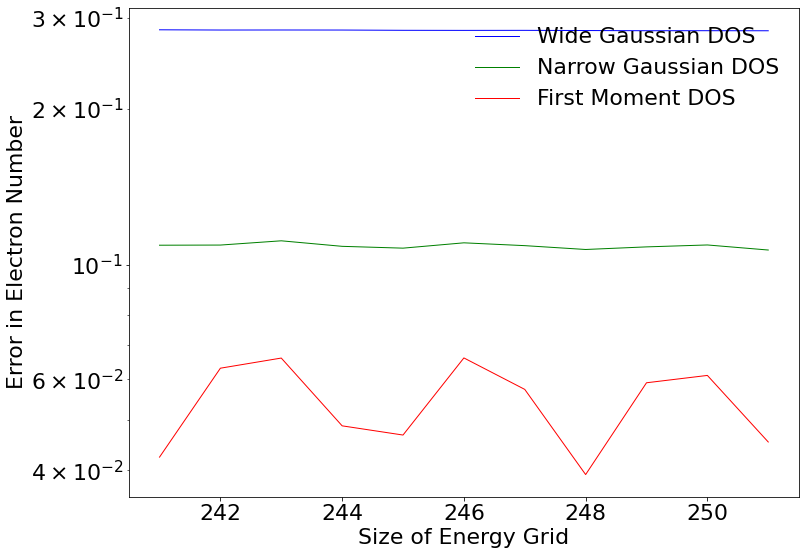

In [66]:
# Plot electron number errors using the three DOS definitions        
plt.figure(figsize=[12,9])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Electron Number')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(np.array(n_egrids), np.abs(enum_error_0_888_2g), linestyle='-',  linewidth=1, color='blue',  label='Wide Gaussian DOS')
ax.plot(np.array(n_egrids), np.abs(enum_error_0_888_g), linestyle='-',  linewidth=1, color='green', label='Narrow Gaussian DOS')
ax.plot(np.array(n_egrids), np.abs(enum_error_0_888_M1), linestyle='-',  linewidth=1, color='red', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
#plt.savefig('E_num_vs_N_grid_all_states.png',dpi=100,bbox_inches='tight')
plt.show()

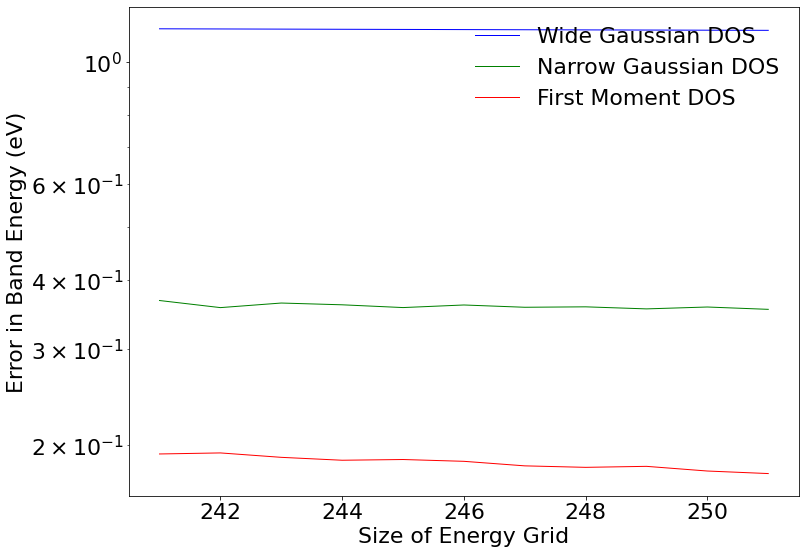

In [67]:
# Plot band energy errors using the three DOS definitions        
plt.figure(figsize=[12,9])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Size of Energy Grid')
ax.set_ylabel(r'Error in Band Energy (eV)')
plt.rcParams.update({'font.size': 22})
plt.yscale("log")

ax.plot(np.array(n_egrids), np.abs(eband_error_0_888_2g), linestyle='-',  linewidth=1, color='blue',  label='Wide Gaussian DOS')
ax.plot(np.array(n_egrids), np.abs(eband_error_0_888_g), linestyle='-',  linewidth=1, color='green', label='Narrow Gaussian DOS')
ax.plot(np.array(n_egrids), np.abs(eband_error_0_888_M1), linestyle='-',  linewidth=1, color='red', label='First Moment DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
#plt.savefig('E_band_vs_N_grid_all_states.png',dpi=100,bbox_inches='tight')
plt.show()

In [68]:
n_egrid = 250
emin = e_grid[0]
emax = e_grid[-1]
n_egrid_max = len(e_grid)
n_egrids = np.arange(n_egrid_max - 10, n_egrid_max + 1)

dosn_0_888_vg = []

sigma = e_grid[1] - e_grid[0]
sigma_multipliers = np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.5,1.7,2.0,2.5,3.0,3.5,4.0])

for sigma_multiplier in sigma_multipliers:
    
    print(sigma_multiplier)
    delta_f = partial(gaussian, sigma = sigma*sigma_multiplier)
    dosn_0_888_vg.append(DOS.from_calculation(dft_0_888, e_grid, delta_f ))

0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.5
1.7
2.0
2.5
3.0
3.5
4.0


In [69]:
enum_error_0_888_vg = []
eband_error_0_888_vg = []
for dos in dosn_0_888_vg:
    enum_error_0_888_vg.append(dos_2_enum(dos, integration = 'analytic') - enum_0_888_ref)
    eband_error_0_888_vg.append(dos_2_eband(dos, e_fermi = 'sc', integration = 'analytic') - eband_0_888_sc_ref)
enum_error_0_888_g = np.array(enum_error_0_888_vg)
eband_error_0_888_g = np.array(eband_error_0_888_vg)

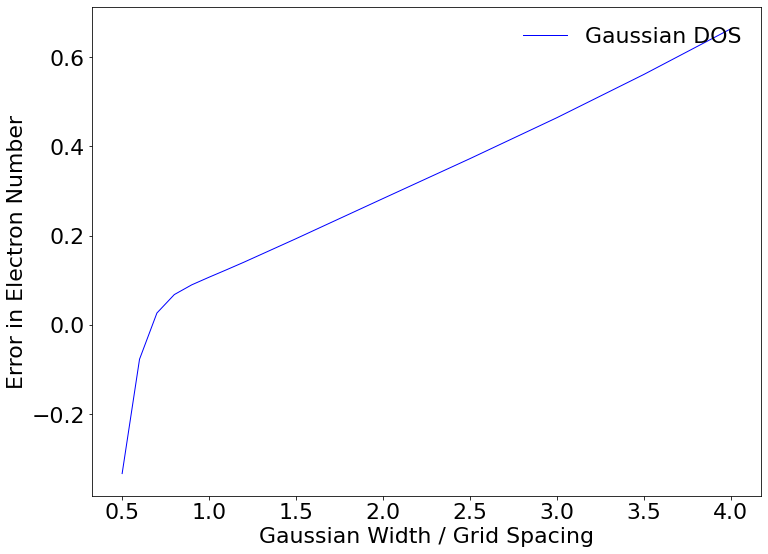

In [70]:
# Plot electron number errors using the three DOS definitions        
plt.figure(figsize=[12,9])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Gaussian Width / Grid Spacing')
ax.set_ylabel(r'Error in Electron Number')
plt.rcParams.update({'font.size': 22})

ax.plot(sigma_multipliers, enum_error_0_888_vg, linestyle='-',  linewidth=1, color='blue',  label='Gaussian DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
#plt.savefig('E_num_vs_G_width_all_states.png',dpi=100,bbox_inches='tight')
plt.show()

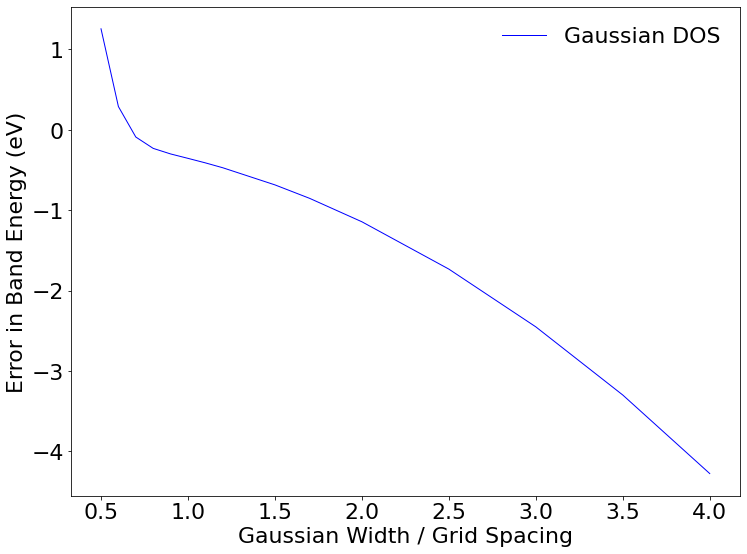

In [71]:
# Plot electron number errors using the three DOS definitions        
plt.figure(figsize=[12,9])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Gaussian Width / Grid Spacing')
ax.set_ylabel(r'Error in Band Energy (eV)')
plt.rcParams.update({'font.size': 22})

ax.plot(sigma_multipliers, eband_error_0_888_vg, linestyle='-',  linewidth=1, color='blue',  label='Gaussian DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1, 1))
#plt.savefig('E_band_vs_G_width_all_states.png',dpi=100,bbox_inches='tight')
plt.show()

# Scratchpad

The cells below include various older calculations and ideas.  Most of them would have to be updated to work with the current code structure.

In [72]:
#ewidth=dos_qe[: , 0][1]-dos_qe[: , 0][0]
ewidth = (dos_qe[: , 0][1]-dos_qe[: , 0][0])*0.5
print(ewidth)
ra_sigma = np.linspace(0.5*ewidth, 5*ewidth, 11)
ra_enum = np.zeros(len(ra_sigma))
ra_eband = np.zeros(len(ra_sigma))
ra_en = np.linspace(dos_qe[0, 0], dos_qe[-1, 0], int((dos_qe[-1, 0]-dos_qe[0, 0])/ewidth)) 
for i in range(len(ra_sigma)):
    print("i:", i)
    # Generate electron number 
    ra_enum[i] = gen_enum(k_weights_qe, ra_en, eigs_qe, sigma=ra_sigma[i])
    # Generate band energy
    ra_eband[i] = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=ra_sigma[i])
print(ra_en[1]-ra_en[0])
print(ra_enum)
print(ra_eband)

NameError: name 'dos_qe' is not defined

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of smearing [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

#ax.set_ylim(767.95, 768.05)

ax.hlines(enum_ref, ra_sigma[0], ra_sigma[-1], linewidth=3)
ax.plot(ra_sigma,  ra_enum, linestyle='-',  linewidth=3, color='blue', label='Electron number')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of smearing [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})


ax.hlines(eband_ref/Ry2eV, ra_sigma[0], ra_sigma[-1], linewidth=3)
ax.scatter(ra_sigma,  ra_eband, linestyle='-',  linewidth=3, color='red', label='Band energy')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()
print(np.min(abs(ra_eband-eband_ref/Ry2eV))/256)

In [ ]:
print(4*ra_sigma[0])

In [ ]:
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=ra_sigma[1] )

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=1, color='red',  label='computed (adjusted width)')
ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=1, color='black', label='QE-DOS')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

In [ ]:
# Generate electron number 
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*0.79255
gen_enum(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )

The "band energy" is also called the "single-particle energy" or the "one-electron energy" and is obtained from a weighted sum of the eigenvalues

$$E_{band} = \sum_i \sum_k w_k\, f(\epsilon_{ik}) \epsilon_{ik}\ .$$

where $i$ labels the band, $k$ labels the k point, $w_k$ is the weight of the k point, and $f(\epsilon_{ik})$ is the occupation of the state, which is given by the Fermi-Dirac distribution function evaluated at energy $\epsilon_{ik}$.

For look at the particular values for a given snapshot (data from ```blake.sandia.gov:/home/acangi/q-e_calcs/Al/datasets/vasp_econ_snapshots/298K/2.699g/170726180545.0/100Ry_k333```). QE prints the one-electron energy in the standard output, together with all the other energy contributions, e.g., 
```
The total energy is the sum of the following terms:                                                  


     one-electron contribution =     737.82754675 Ry
     hartree contribution      =       4.77073244 Ry
     xc contribution           =    -554.09988814 Ry
     ewald contribution        =   -1375.56724973 Ry
     smearing contrib. (-TS)   =      -0.02019845 Ry
```
However, what QE prints as the "one-electron contribution" is not the sum of the eigenvalues, but instead (see source code ```~/PW/src/electrons.f90``` lines 638-640)

$$\text{one-electron contribution} = \sum_i \epsilon_i - (E_h + E_{xc})$$

In order to correctly compare the band energy obtained from integrating the DOS with the QE output we need to add the hartree and exchange-correlation contributions to the one-electron contribution.

In [ ]:
737.82754675

The correct band energy from QE output is

In [ ]:
eband_qe = 737.82754675+4.77073244-554.09988814
print(eband_qe)

Error in band energy compared to QE output

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

By adjusting the width of the Gaussian smearing we achieved the desired accuracy in the band energy, here < 1 meV.
The corresponding DOS looks like this:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

However, we can also increase the smearing width and also obtain an accurate band energy.

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]
emax = dos_qe[: , 0][-1]
ra_en = dos_qe[: , 0]
sigma_mod = sigma_qe*29.177
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

The corresponding DOS looks like this:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

We can also generate a different energy grid. However, it the integral quickly converges with respect to the number of grid points. We can increase the range of the enegy grid to make sure the DOS decays to zero at the limits.

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]-1
emax = dos_qe[: , 0][-1]+1
# Decrease the number of energy grid points
ra_en = np.linspace(emin, emax, int(len(dos_qe[: , 0])))
sigma_mod = sigma_qe*29.908
eband = gen_eband(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

The corresponding DOS looks like:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0], dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en        , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

Check for another snapshot.
The band energy from the QE output of snapshot 1 is:

In [ ]:
eband_qe_01 = 739.08601067+4.18224128-553.98606038
print(eband_qe_01)

In [ ]:
ewidth_01=dos_qe_01[: , 0][1]-dos_qe_01[: , 0][0]
print(ewidth_01)
emin = dos_qe_01[: , 0][0]-1
emax = dos_qe_01[: , 0][-1]+1
ra_en_01 = np.linspace(emin, emax, int(len(dos_qe_01[: , 0])))
ra_sigma_01 = np.linspace(20*ewidth_01, ewidth_01, 101)
ra_enum_01 = np.zeros(len(ra_sigma_01))
ra_eband_01 = np.zeros(len(ra_sigma_01))
for i in range(len(ra_sigma)):
    ra_en_01 = dos_qe[: , 0]
    # Generate electron number 
    ra_enum_01[i] = gen_enum(k_weights_qe_01, ra_en_01, eigs_qe_01, sigma=ra_sigma_01[i])
    # Generate band energy
    ra_eband_01[i] = gen_eband(k_weights_qe_01, ra_en_01, eigs_qe_01, sigma=ra_sigma_01[i])
print(ra_enum_01)
print(ra_eband_01)

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of energy bin [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.hlines(768, ra_sigma_01[0], ra_sigma_01[-1], linewidth=3)
ax.plot(ra_sigma_01,  ra_enum_01, linestyle='-',  linewidth=3, color='blue', label='Electron number')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'Width of energy bin [Ry]')
#ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.hlines(eband_qe_01, ra_sigma_01[0], ra_sigma_01[-1], linewidth=3)
ax.plot(ra_sigma_01,  ra_eband_01, linestyle='-',  linewidth=3, color='red', label='Band energy')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Generate band energy
emin = dos_qe_01[: , 0][0]-1
emax = dos_qe_01[: , 0][-1]+1
# Decrease the number of energy grid points
ra_en = np.linspace(emin, emax, 2*int(len(dos_qe_01[: , 0])))
sigma_mod = sigma_qe*22.90#22.882
eband_01 = gen_eband(k_weights_qe_01, ra_en , eigs_qe_01, sigma=sigma_mod )
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband_01))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error_01 = eband_01-eband_qe_01
print("Error in Rydberg", eband_error_01)
print("Error in eV", eband_error_01*Ry2eV)

The corresponding DOS looks like:

In [ ]:
# Generate data
ra_dos = gen_DOS(k_weights_qe_01, ra_en, eigs_qe_01, sigma=sigma_mod )
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe_01[: , 0], dos_qe_01[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(ra_en           , ra_dos,           linestyle='-',  linewidth=3, color='red',   label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()

This illustrates the issue with Gaussian smearing. The smearing width differs between the different snapshots. This means we cannot choose a fixed smearing width and obtain high accuracy in the band energy throughout a priori (i.e. without knowing the true value of the band energy). However, this might be fine, since we need to choose the smearing width only for the generation of training data. It might be somewhat inconvenient, but for each snapshot in the training data we can find the corresponding smearing width which will yield a band energy up to a target accuracy.

To do
* Perform search over smearing width using sp.optimize library. But this requires adapting the definitions of the functions above.
* Different representation of the $\delta$ function, for example Marzari-Vanderbilt (MV).

In [ ]:
# Define MV representation of delta function
def MV(en, mu, sigma):
    x = (mu-en)/sigma
    result = 1.0/np.sqrt(np.pi)*(2.0-np.sqrt(2)*x)*np.exp(-1.0*(x-(1.0/np.sqrt(2)))**2)
    return result

In [ ]:
# Sanity check of smearing functions
# Generate data
ra_en = np.linspace(7.,9.,601)
ra_gaussian = gaussian(ra_en, eF=fermi_energy, sigma=sigma_qe)
ra_MV = MV(ra_en, mu=fermi_energy, sigma=sigma_qe*2)
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(ra_en, ra_MV, linestyle='-',  linewidth=3, color='red', label='MV')
#ax.plot(ra_en, ra_gaussian, linestyle='-',  linewidth=3, color='blue', label='gaussian')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Function generating DOS from eigenvalues
def gen_DOS_ST(k_weights, array_en, array_eigs, sigma, smearing_type):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    dim_bnd = len((array_eigs[: , 0]))
    dim_k = len((array_eigs[0 , :]))
    ra_en = array_en #dos_qe[: , 0]       # energy grid (same as QE-DOS input/output) 
    ra_dos_ik = [[] for i in range(dim_bnd)]
    ra_dos = np.zeros(len(array_en)) #create empty array
    for idx_bnd in range(dim_bnd):
        for idx_k in range(dim_k):
            if (smearing_type == 1):
                smearing = gaussian(en=array_en, eF=array_eigs[idx_bnd , :][idx_k], sigma=sigma)
            elif (smearing_type == 2):
                smearing = MV(en=array_en, mu=array_eigs[idx_bnd , :][idx_k], sigma=sigma)
            else:
                print("Error, choose valid smearing function.")
            ra_dos_ik[idx_bnd].append(smearing)
            # Sum the Gaussians over idx_band and idx_k
            ra_dos += k_weights[idx_k]*ra_dos_ik[idx_bnd][idx_k]
    return ra_dos #, ra_dos_ik

In [ ]:
# Generate data
ra_en = dos_qe[: , 0]
ra_dos = gen_DOS_ST(k_weights_qe, ra_en, eigs_qe, sigma=sigma_qe*Ry2eV,smearing_type=2)

# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='--', linewidth=3, color='red',  label='computed')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.5, 1))
plt.show()

In [ ]:
# Function generating band energy from DOS
## Integrate DOS*E*FD to obtain band energy
def gen_eband_ST(k_weights, array_en, array_eigs, sigma, smearing_type):
    # input:
    ## k_weights: weights of k-point summation (taken from QE output)
    ## array_en: energy grid [eV]
    ## array_eigs: array[dim_bnd, dim_k] containing eigenvalues (\epsilon_{i,k})
    ## sigma: width of Gaussian [eV]
    # output:
    ## array_dos: ra_dos
    ## array_dos_contr: ra_dos_ik (terms for each i,k)
    ra_fd = fd_function(array_en, eF=fermi_energy, t=temp)
    #ra_dos, ra_dos_ik = gen_DOS(k_weights_qe, array_en, eigs_qe, sigma)
    ra_dos = gen_DOS_ST(k_weights_qe, array_en, eigs_qe, sigma, smearing_type)
    eband = sp.integrate.trapz(ra_dos*array_en*ra_fd, array_en)
    #Convert from eV to Ry for comparison with QE output
    eband_Ry = eband/Ry2eV
    return eband_Ry

In [ ]:
# Generate band energy
emin = dos_qe[: , 0][0]-1
emax = dos_qe[: , 0][-1]+1
ra_en = np.linspace(emin, emax, int(len(dos_qe[: , 0])))
sigma_mod = sigma_qe*30.56825
eband = gen_eband_ST(k_weights_qe, ra_en , eigs_qe, sigma=sigma_mod, smearing_type=2)
print("smearing width {0} eV ({1} Ry)".format(sigma_mod, sigma_mod/Ry2eV))
print("Band energy {0} Ry)".format(eband))

In [ ]:
# Error in band energy (due to discretization of the energy grid in DOS calculation and choice of smearing width)
eband_error = eband-eband_qe
print("Error in Rydberg", eband_error)
print("Error in eV", eband_error*Ry2eV)

In [ ]:
# Generate data
ra_dos = gen_DOS_ST(k_weights_qe, ra_en, eigs_qe, sigma=sigma_mod, smearing_type=2)
        
# Plot data        
plt.figure(figsize=[8,6])
ax = plt.subplot(1,1,1)
ax.set_xlabel(r'E [eV]')
ax.set_ylabel(r'D(E)')
plt.rcParams.update({'font.size': 22})

ax.plot(dos_qe[: , 0],  dos_qe[: , 1], linestyle='-',  linewidth=3, color='black', label='QE-DOS')
ax.plot(dos_qe[: , 0] , ra_dos,        linestyle='-',  linewidth=3, color='red',  label='computed (adjusted width)')

# Legend
ax.legend(loc='upper right',frameon=False, bbox_to_anchor=(2, 1))
plt.show()